# Analyzing Unstructured Data

In this tutorial you will learn to:

* [web/screen scrape](https://en.wikipedia.org/wiki/Web_scraping) relatively unstructured data from the Wikipedia
* transform unstructured data into tabular data to facilitate processing with Python
* create graph data from your data to visualize your data as networks
* export Python-created data to use it with JavaScript visualization libraries such as [D3.js](https://d3js.org/)

Would you should already know:

* a little Python 3
* some minor HTML
* some JavaScript if you want to understand the web-based visualization at the end of the tutorial

This notebook assumes that you are using [Anaconda](https://www.anaconda.com/download/) as your Python 3 distribution.

# TODO

* DC und MArvel gegenüberstellen,
* WEbsite entsprechend anpassen
* auf Partnerships eingehen
* Konzepte in den Abilities bzw. Sentiments extrahieren
* entsprechende Wikipedia-Artikel auf Sentiments hin analysieren
* Korrelationen heraussuchen (einsame Superhelden mit negativen Artikeln in der Wikipedia?)

## Preparing Your Environment

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from bs4 import BeautifulSoup
from collections import OrderedDict # provides the ordered dictionary
import re # for regular expressions used below
import urllib # to read from URLs
import networkx as nx # network analysis
import itertools
from datetime import datetime # for time measurement
import sys
import os
import unicodedata as ucd

# utility method that displays a given text and the current time
def printLog(text):
    now=str(datetime.now())
    print("["+now+"]\t"+text)
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()

This notebook can be used to work with superheroes of the DC Comics or Marvel universe. However, only one universe can be processed at once.

In [2]:
isMarvel=True

if isMarvel:
    # Marvel
    imageDownloadPath="./web/force/img.marvel_chars/"
    csvFilePath="marvel_superheroes.csv"
    pathPrefix="marvel"
else:
    # DC Comics
    imageDownloadPath="./web/force/img.dc_chars/"
    csvFilePath="dc_superheroes.csv"
    pathPrefix="dc"

# if the needed paths do not exist, create them
if not os.path.exists(imageDownloadPath):
    os.mkdir(imageDownloadPath)

## Screen-Scraping
Anaconda comes with _Beautiful Soup_, a library for screen-scraping [documentation](http://www.crummy.com/software/BeautifulSoup/bs4/doc/). The main idea is to download a HTML page from the Wikipedia, parse its contents, and save it in a structed way. This functionality is encapsulated in the function _extractData()_ (see below).

The relevant data is hidden in a table with the CSS class infobox. The th tags serve as separators for the following information:
* <th scope="row" style="width: 40%;">Alter ego</th>
* <th scope="row" style="width: 40%;">Team affiliations</th>
* <th scope="row" style="width: 40%;">Partnerships</th>
* <th scope="row" style="width: 40%;">Notable aliases</th>
* <th scope="row" style="width: 40%;">Abilities</th>

The function also relies on [_regular expressions_](https://docs.python.org/2/howto/regex.html) - if you haven't heard of them before...

In [3]:
def extractData(myDoc): # myDoc is the HTML document to be parsed
    # initialize the screen-scraper
    soup = BeautifulSoup(myDoc, 'html.parser')
    # during an inspection of the Wikipedia HTML, we discovered that table elements with the CSS class infobox have to be parsed
    tables=soup.find_all('table',class_="infobox")
    # if there is no infobox, ignore the page
    if len(tables)>=1:
        infoboxTable=tables[0]
        # try to get the name of the character
        if infoboxTable.tr.th is not None:
            name=infoboxTable.tr.th.get_text()
        else:
            #if it is not part of the infobox take it from the HTML page's title and strip the Wikipedia reference
            name=soup.title.get_text().replace(" - Wikipedia, the free encyclopedia","")
        abilityRow=None
        partnerRow=None
        firstAppearance="2020" # dummy entry in case the "first appearance" entry is missing
        abilities=[]
        partnerships=[]
        
        # save the provided image for later processing
        if infoboxTable.find('img'):
            articleImage=infoboxTable.find('img')["src"]
        else:
            articleImage=None

        p = re.compile('\d\d\d\d') # we expect the year of first appearance to have four digits
        
        rows=infoboxTable.find_all("tr")
        for row in rows:
            if row.th is not None and row.th.string == "First appearance":
                rawText=row.td.get_text()
                m = p.search(rawText)
                # deal with missing years of first appearance
                if m:
                    firstAppearance=m.group()
            elif row.th is not None and row.th.string == "Abilities":
                abilityRow=row
            elif row.th is not None and row.th.string == "Partnerships":
                partnerRow=row

        # as not every page has a "complete" infobox, we have to check the presence of abilities and partnerships
        if abilityRow is not None:
            li=abilityRow.find_all("li")
            for l in li:
                # check if an anchor (a link to a website) is contained
                if l.a is not None:
                    # if so, discard the link and keep the plain text
                    l.a.unwrap()
                abilities.append(l.get_text().strip())
        # a fix for abilities without the ul/li structure
            if len(li)==0:
                rawStr=str(abilityRow.td)
                rawStr=rawStr.replace("<td>","").replace("</td>","").replace("\n","").strip()
                # abilities are sometimes separated by  <br/>, a comma, a period, or "and"
                rawStr=rawStr.replace("<br/>",";")
                rawStr=rawStr.replace(",",";")
                rawStr=rawStr.replace(".",";")
                # we have to treat 'and' in a special way as it may be contained as a substring in "normal" words
                #rawStr=rawStr.replace("and",";")
                rawTokens=rawStr.split(" and ")
                rawStr=";".join(rawTokens)
                # remove all other HTML tags
                p2 = re.compile(r'<.*?>')
                rawStr=p2.sub(' ', rawStr)
                # clean whitespaces surrounding the string
                rawStr.strip()
                rawTokens=rawStr.split(";")
                for t in rawTokens:
                    t=t.strip()
                    # we have to ignore additional noise such as the following "abilities"
                    if t.lower()=="see below":
                        pass
                    elif t.lower()=="various":
                        pass
                    elif t.lower()=="varies":
                        pass
                    elif t.lower()=="none":
                        pass
                    else:
                        if str(t):
                            abilities.append(str(t))

        if partnerRow is not None:
            partners=partnerRow.find_all("a")
            for p in partners:
                if p.string is not None: # some Marvel pages "suffer" from empty <a>
                    partnerships.append(p.string)

        
        
        result=dict()
        result["name"]=name
        result["firstAppearance"]=int(firstAppearance)
        result["abilities"]=abilities
        result["abilitiesCount"]=len(abilities)
        result["partnerships"]=partnerships
        result["partnershipsCount"]=len(partnerships)
        if articleImage:
            result["imageURL"]="https:"+str(articleImage)
        else:
            result["imageURL"]="https://None"
        #print abilities
        return result
    else:
        return None

### Testing the Function
In order to find out whether the function works, we call it with two superheroes.

In [4]:
html_doc=urllib.request.urlopen("https://en.wikipedia.org/wiki/Juggernaut_(comics)")
r=extractData(html_doc)
print(r)

print("\n NEXT SUPERHERO\n")

html_doc=urllib.request.urlopen("https://en.wikipedia.org/wiki/Batman")
r=extractData(html_doc)
print(r)

{'name': 'Juggernaut', 'firstAppearance': 1965, 'abilities': ['Superhuman strength', 'durability', 'Invulnerability via mystical force field', 'Virtually unstoppable momentum', 'Immunity to mental attacks via his helmet'], 'abilitiesCount': 5, 'partnerships': ['Black Tom Cassidy'], 'partnershipsCount': 1, 'imageURL': 'https://upload.wikimedia.org/wikipedia/en/thumb/4/44/Juggernaut2.PNG/250px-Juggernaut2.PNG'}

 NEXT SUPERHERO

{'name': 'Batman', 'firstAppearance': 1939, 'abilities': ['Genius-level intellect', 'Peak human physical condition', 'Skilled martial artist and hand-to-hand combatant', 'Expert detective', 'Utilizes high-tech equipment and weapons'], 'abilitiesCount': 5, 'partnerships': ['Robin', 'James Gordon', 'Catwoman', 'Batgirl', 'Superman', 'Wonder Woman'], 'partnershipsCount': 6, 'imageURL': 'https://upload.wikimedia.org/wikipedia/en/thumb/8/87/Batman_DC_Comics.png/220px-Batman_DC_Comics.png'}


However, the reality is more complex but the Wikipedia provides lists of superheroes of the different universes.

In [5]:
categoryPages=[]
if not isMarvel:
    # DC superheroes
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pageuntil=Dragon+King%0ADragon+King+%28DC+Comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=Krypto#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=Robin%0ARobin+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=XS+%28comics%29#mw-pages")
    # general DC characters
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_characters&pageuntil=Smoak%2C+Felicity%0AFelicity+Smoak#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_characters&pagefrom=Smoak%2C+Felicity%0AFelicity+Smoak#mw-pages")
else:
    # Marvel superheroes
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pageuntil=Dazzler#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Dazzler#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Jameson%0AJohn+Jameson+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Prime+%28Comics%29%0APrime+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Talon+%28Marvel+Comics%29#mw-pages")

The following function expects Wikipedia category pages as provided above and retrieves the URLs of relevant superhero Wikipedia articles.

In [6]:
def getSuperheroes(myCategories,myDictionary):
    for c in myCategories:
    # ignore <a class="mw-redirect"> as they redirect into articles, 
    # to be precise, we only consider <a> tags without a class atrribute 
    # because we are only interested in superheroes with distinct wikipedia articles
        items=c.ul.find_all("li")
        for item in items:
            if item.a.get("class") is None:
                myDictionary[item.a["title"]]=item.a["href"]


startTime=datetime.now()
printLog("Fetching superhero URLs...")

superheroes=OrderedDict() # we use an ordered dict here because we want to preserve the order items were added
for catPage in categoryPages:
    html_doc=urllib.request.urlopen(catPage)
    soup = BeautifulSoup(html_doc, 'html.parser')
    categories=soup.select("#mw-pages")[0].select(".mw-category-group")
    getSuperheroes(categories,superheroes) # we pass the superheroes dictionary on to merge the heroes extracted from all pages

duration=datetime.now()-startTime
printLog("Processing completed in "+str(duration)+".")

[2019-02-06 20:53:18.442988]	Fetching superhero URLs...
[2019-02-06 20:53:20.986803]	Processing completed in 0:00:02.543796.


Given a list of URLs, we can extract the data for each superhero.

In [7]:
wikiBaseURL="https://en.wikipedia.org"
heroFeats=[]
i=0;
countItems=len(superheroes)

printLog("Processing "+str(countItems)+" Wikipedia pages. This will take a while...")

startTime=datetime.now()


for key, value in superheroes.items():
    i=i+1
    wikiURL=wikiBaseURL+value
    #print "Processing "+wikiURL+" ; "+str(i)+" of "+str(countItems)
    html_doc=urllib.request.urlopen(wikiURL)
    r=extractData(html_doc)
    if r:
        r["url"]=wikiURL
        heroFeats.append(r)
    else:
        print("\t"+wikiURL+" does not contain an infobox. Processing aborted.")

duration=datetime.now()-startTime
printLog("Processing completed in "+str(duration)+".")

[2019-02-06 20:54:17.032331]	Processing 814 Wikipedia pages. This will take a while...
	https://en.wikipedia.org/wiki/Citizen_V does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Human_Top_(Bruce_Bravelle) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Pixx does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Red_Hulk does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Sequoia_(comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Thunderstrike_(comics) does not contain an infobox. Processing aborted.
[2019-02-06 20:57:54.295710]	Processing completed in 0:03:37.262216.


Additionally, we will download the character images if there are some.

In [8]:
printLog("Downloading images. This will take a while...")

startTime=datetime.now()
# downloading images

if not os.path.exists(imageDownloadPath):
    os.makedirs(imageDownloadPath)

for i,hero in enumerate(heroFeats):
    hero["localFilePath"]="N/A" # caveat of JSON http://stackoverflow.com/questions/13715891/d3-json-uncaught-typeerror-cannot-read-property-children-of-undefined
    iURL=hero["imageURL"]
    if not iURL=="https://None":
        tokens=iURL.split(".")
        suffix=tokens[-1]
        localFilePath=imageDownloadPath+str(i)+"."+suffix
        hero["localFilePath"]=localFilePath
        try:
            urllib.request.urlretrieve(iURL,localFilePath)
        except IOError: # if we would catch all other exception, we would have a hard time to stop the kernel at all
            print("Downloading error while accessing: "+hero["imageURL"])
duration=datetime.now()-startTime
printLog("Downloading completed in "+str(duration)+".")

[2019-02-06 21:00:11.289706]	Downloading images. This will take a while...
[2019-02-06 21:01:57.011318]	Downloading completed in 0:01:45.720406.


## Converting the Raw Data into Tables

For further processing relying on Python's typical data science libraries, it is handy to save the data in a Pandas [DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html), a tabular data structure with built-in support for various analytical tasks.

In [9]:
rows=[]
columns=["Name","Year","Decade","Abilities","AbilitiesCount","Partnerships","PartnershipsCount","URL","ImageURL","localFilePath"]

# take each hero and save attributes in a data frame
for hero in heroFeats:
    rowx=[]
    rowx.append(hero["name"])
    firstAp=hero["firstAppearance"]
    rowx.append(firstAp)
    # calculate the decade
    if firstAp<2000:
        rowx.append(1900+int((hero["firstAppearance"]-1900)/10)*10)
    else:
        rowx.append(2000+int((hero["firstAppearance"]-2000)/10)*10)
    rowx.append(",".join(hero["abilities"]))
    rowx.append(hero["abilitiesCount"])
    rowx.append(",".join(hero["partnerships"]))
    rowx.append(hero["partnershipsCount"])
    rowx.append(hero["url"])
    rowx.append(hero["imageURL"])
    rowx.append(hero["localFilePath"])
    rows.append(rowx)

df=pd.DataFrame(rows,columns=columns)
df.head() # display the top rows of the data frame

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath
0,Abigail Brand,2004,2000,Pyrokinesis,1,Beast,1,https://en.wikipedia.org/wiki/Abigail_Brand,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/0.png
1,Adept,1986,1980,"Hyper-invention/ hyper-intelligence,Chemical m...",3,,0,https://en.wikipedia.org/wiki/Adept_(comics),https://upload.wikimedia.org/wikipedia/en/f/f4...,./web/force/img.marvel_chars/1.jpg
2,Agent X,2002,2000,"Regenerative healing factor,Superhuman ambidex...",10,,0,https://en.wikipedia.org/wiki/Agent_X_(Marvel_...,https://upload.wikimedia.org/wikipedia/en/a/a9...,./web/force/img.marvel_chars/2.jpg
3,El Águila,1979,1970,"Skilled fencer,Excellent acrobat,hand to hand ...",4,,0,https://en.wikipedia.org/wiki/El_Aguila,https://None,N/A
4,Aikku Jokinen,2013,2010,"Alien suit grants:,Flight,Shield generation,In...",7,,0,https://en.wikipedia.org/wiki/Aikku_Jokinen,https://None,N/A


Unfortunately, the table is not ready for processing. For instance, the superheroe's name are using lower and upper case letters which would complicate later comparisons. There are also encoding issues. Hence, we normalize textual date before we continue with the analysis.

To simplify the code, we rely on [lambda functions](https://www.w3schools.com/python/python_lambda.asp), anonymous functions that get applied on most attributes of the data frame. In order to be non-destructive, we save the results in separate columns.

In [10]:
# to avoid spelling issues, we capitalize all superheroes' names
# lambda Konzept erläutern
try:
    df['NameCaps'] = df.Name.apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['NameCaps'] = df.Name.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
#    utf8str=row[13].decode('utf-8')
#    str2=ucd.normalize('NFKD', utf8str).encode('ascii','ignore')
try:
    df['PartnershipsCaps'] = df.Partnerships.astype(str).apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['PartnershipsCaps'] = df.Partnerships.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
try:
    df['AbilitiesCaps'] = df.Abilities.astype(str).apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['AbilitiesCaps'] = df.Abilities.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
df.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abigail Brand,2004,2000,Pyrokinesis,1,Beast,1,https://en.wikipedia.org/wiki/Abigail_Brand,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/0.png,ABIGAIL BRAND,BEAST,PYROKINESIS
1,Adept,1986,1980,"Hyper-invention/ hyper-intelligence,Chemical m...",3,,0,https://en.wikipedia.org/wiki/Adept_(comics),https://upload.wikimedia.org/wikipedia/en/f/f4...,./web/force/img.marvel_chars/1.jpg,ADEPT,,"HYPER-INVENTION/ HYPER-INTELLIGENCE,CHEMICAL M..."
2,Agent X,2002,2000,"Regenerative healing factor,Superhuman ambidex...",10,,0,https://en.wikipedia.org/wiki/Agent_X_(Marvel_...,https://upload.wikimedia.org/wikipedia/en/a/a9...,./web/force/img.marvel_chars/2.jpg,AGENT X,,"REGENERATIVE HEALING FACTOR,SUPERHUMAN AMBIDEX..."
3,El Águila,1979,1970,"Skilled fencer,Excellent acrobat,hand to hand ...",4,,0,https://en.wikipedia.org/wiki/El_Aguila,https://None,N/A,EL ÁGUILA,,"SKILLED FENCER,EXCELLENT ACROBAT,HAND TO HAND ..."
4,Aikku Jokinen,2013,2010,"Alien suit grants:,Flight,Shield generation,In...",7,,0,https://en.wikipedia.org/wiki/Aikku_Jokinen,https://None,N/A,AIKKU JOKINEN,,"ALIEN SUIT GRANTS:,FLIGHT,SHIELD GENERATION,IN..."


Finally, we save the results as a CSV file. However, Excel, a database, or many more other formats would also be possible. This is also a good place to take a rest and continue later on.

In [11]:
# save to file without the index columns of the data frame and separate each field with a tabstop
df.to_csv(csvFilePath,index=False,header=True,encoding='utf-8', sep="\t")

## Continuing the Analysis
If you have shutdown the notebook before, you can read in the data again with [read_csv()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html).

In [12]:
df=pd.read_csv(csvFilePath,encoding='utf-8', sep="\t",dtype={"Partnerships":'str'})
df.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abigail Brand,2004,2000,Pyrokinesis,1,Beast,1,https://en.wikipedia.org/wiki/Abigail_Brand,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/0.png,ABIGAIL BRAND,BEAST,PYROKINESIS
1,Adept,1986,1980,"Hyper-invention/ hyper-intelligence,Chemical m...",3,NaN,0,https://en.wikipedia.org/wiki/Adept_(comics),https://upload.wikimedia.org/wikipedia/en/f/f4...,./web/force/img.marvel_chars/1.jpg,ADEPT,NaN,"HYPER-INVENTION/ HYPER-INTELLIGENCE,CHEMICAL M..."
2,Agent X,2002,2000,"Regenerative healing factor,Superhuman ambidex...",10,NaN,0,https://en.wikipedia.org/wiki/Agent_X_(Marvel_...,https://upload.wikimedia.org/wikipedia/en/a/a9...,./web/force/img.marvel_chars/2.jpg,AGENT X,NaN,"REGENERATIVE HEALING FACTOR,SUPERHUMAN AMBIDEX..."
3,El Águila,1979,1970,"Skilled fencer,Excellent acrobat,hand to hand ...",4,NaN,0,https://en.wikipedia.org/wiki/El_Aguila,https://None,NaN,EL ÁGUILA,NaN,"SKILLED FENCER,EXCELLENT ACROBAT,HAND TO HAND ..."
4,Aikku Jokinen,2013,2010,"Alien suit grants:,Flight,Shield generation,In...",7,NaN,0,https://en.wikipedia.org/wiki/Aikku_Jokinen,https://None,NaN,AIKKU JOKINEN,NaN,"ALIEN SUIT GRANTS:,FLIGHT,SHIELD GENERATION,IN..."


Next, we will test wheter all superhero names are unique - a valid hypothesis...

In [13]:
countNames=df.NameCaps.count()
uniqueNames=len(df.NameCaps.unique())

print("Total number of names: %d, Unique number of names: %d" % (countNames,uniqueNames))
if countNames!=uniqueNames:
    print("Attention! Names are not unique.")

Total number of names: 808, Unique number of names: 768
Attention! Names are not unique.


Unfortunately, the names are not unique.
To drop the duplicates, we apply a rather simple strategy: we keep the oldest, i.e., the first appearing, superheroes using pandas utility function [drop_duplicates()](http://pandas.pydata.org/pandas-docs/version/0.17.1/generated/pandas.DataFrame.drop_duplicates.html).

In [14]:
df.drop_duplicates(subset='NameCaps',keep='first',inplace=True)

countNames=df.NameCaps.count()
uniqueNames=len(df.NameCaps.unique())

print("Total number of names: %d, Unique number of names: %d" % (countNames,uniqueNames))
if countNames!=uniqueNames:
    print("Attention! Names are not unique.")

Total number of names: 768, Unique number of names: 768


After we made sure that every superhero appears only once, we will try to find out if there are "lone wolf" characters. These heros are copied into a new data frame.
Further selections are made for demonstration purposes...

In [15]:
# the "lonely" superheroes are created from the original data frame selecting each row where the column "Partnerships" is Null (not set)
df2=df[df["Partnerships"].isnull()]
df2.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
1,Adept,1986,1980,"Hyper-invention/ hyper-intelligence,Chemical m...",3,NaN,0,https://en.wikipedia.org/wiki/Adept_(comics),https://upload.wikimedia.org/wikipedia/en/f/f4...,./web/force/img.marvel_chars/1.jpg,ADEPT,NaN,"HYPER-INVENTION/ HYPER-INTELLIGENCE,CHEMICAL M..."
2,Agent X,2002,2000,"Regenerative healing factor,Superhuman ambidex...",10,NaN,0,https://en.wikipedia.org/wiki/Agent_X_(Marvel_...,https://upload.wikimedia.org/wikipedia/en/a/a9...,./web/force/img.marvel_chars/2.jpg,AGENT X,NaN,"REGENERATIVE HEALING FACTOR,SUPERHUMAN AMBIDEX..."
3,El Águila,1979,1970,"Skilled fencer,Excellent acrobat,hand to hand ...",4,NaN,0,https://en.wikipedia.org/wiki/El_Aguila,https://None,NaN,EL ÁGUILA,NaN,"SKILLED FENCER,EXCELLENT ACROBAT,HAND TO HAND ..."
4,Aikku Jokinen,2013,2010,"Alien suit grants:,Flight,Shield generation,In...",7,NaN,0,https://en.wikipedia.org/wiki/Aikku_Jokinen,https://None,NaN,AIKKU JOKINEN,NaN,"ALIEN SUIT GRANTS:,FLIGHT,SHIELD GENERATION,IN..."
5,Air-Walker - Wikipedia,1972,1970,Power Cosmic,1,NaN,0,https://en.wikipedia.org/wiki/Air-Walker,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/5.jpg,AIR-WALKER - WIKIPEDIA,NaN,POWER COSMIC


In [16]:
# the "sociable" superheroes
df3=df[df["Partnerships"].notnull()]
df3.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abigail Brand,2004,2000,Pyrokinesis,1,Beast,1,https://en.wikipedia.org/wiki/Abigail_Brand,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/0.png,ABIGAIL BRAND,BEAST,PYROKINESIS
10,Andromeda,1985,1980,"Superhuman strength,durability,Ability to brea...",3,Namor,1,https://en.wikipedia.org/wiki/Andromeda_(Marve...,https://upload.wikimedia.org/wikipedia/en/2/2d...,./web/force/img.marvel_chars/10.jpg,ANDROMEDA,NAMOR,"SUPERHUMAN STRENGTH,DURABILITY,ABILITY TO BREA..."
15,Scott Lang,1979,1970,Ability to shrink to sub-microscopic size and ...,9,"Hank Pym,Wasp",2,https://en.wikipedia.org/wiki/Ant-Man_(Scott_L...,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/15.jpg,SCOTT LANG,"HANK PYM,WASP",ABILITY TO SHRINK TO SUB-MICROSCOPIC SIZE AND ...
17,Aragorn,1968,1960,"Flight via feathered wings,Enhanced intelligen...",3,"Black Knight,Valkyrie",2,https://en.wikipedia.org/wiki/Aragorn_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/17.jpg,ARAGORN,"BLACK KNIGHT,VALKYRIE","FLIGHT VIA FEATHERED WINGS,ENHANCED INTELLIGEN..."
18,Anya Corazon,2004,2000,"Superhuman strength, speed, agility, stamina, ...",4,Ms. Marvel,1,https://en.wikipedia.org/wiki/Anya_Corazon,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/18.jpg,ANYA CORAZON,MS. MARVEL,"SUPERHUMAN STRENGTH, SPEED, AGILITY, STAMINA, ..."


In [17]:
# the oldest superhero(ine)
df[df['Year']==df['Year'].min()]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
11,The Angel,1939,1930,"Excellent acrobat,hand to hand combatant,Accom...",9,NaN,0,https://en.wikipedia.org/wiki/Angel_(Thomas_Ha...,https://upload.wikimedia.org/wikipedia/en/4/4c...,./web/force/img.marvel_chars/11.png,THE ANGEL,NaN,"EXCELLENT ACROBAT,HAND TO HAND COMBATANT,ACCOM..."
465,Namor the Sub-Mariner,1939,1930,"Aquatic adaptation,Superhuman strength,speed,a...",11,"Namora,Namorita,Fin,Dorma,Stingray",5,https://en.wikipedia.org/wiki/Namor,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/465.jpg,NAMOR THE SUB-MARINER,"NAMORA,NAMORITA,FIN,DORMA,STINGRAY","AQUATIC ADAPTATION,SUPERHUMAN STRENGTH,SPEED,A..."


In [18]:
# get the superhero with the maximal number of abilities
df[df['AbilitiesCount']==df['AbilitiesCount'].max()]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
337,John Jameson,1963,1960,"Skilled pilot,astronaut,Experienced hand-to-ha...",32,NaN,0,https://en.wikipedia.org/wiki/John_Jameson_(co...,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/337.png,JOHN JAMESON,NaN,"SKILLED PILOT,ASTRONAUT,EXPERIENCED HAND-TO-HA..."


In [19]:
# select superheroes that first appeared during 1939 and 1945
df[(df.Year>=1939) & (df.Year<1945)]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
11,The Angel,1939,1930,"Excellent acrobat,hand to hand combatant,Accom...",9,NaN,0,https://en.wikipedia.org/wiki/Angel_(Thomas_Ha...,https://upload.wikimedia.org/wikipedia/en/4/4c...,./web/force/img.marvel_chars/11.png,THE ANGEL,NaN,"EXCELLENT ACROBAT,HAND TO HAND COMBATANT,ACCOM..."
42,Golden Girl,1941,1940,"Skilled hand-to-hand combatant,Wears bulletpro...",2,NaN,0,https://en.wikipedia.org/wiki/Betsy_Ross_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/42.jpg,GOLDEN GIRL,NaN,"SKILLED HAND-TO-HAND COMBATANT,WEARS BULLETPRO..."
53,Black Marvel,1941,1940,"Excellent hand to hand combatant,Peak physical...",2,NaN,0,https://en.wikipedia.org/wiki/Black_Marvel,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/53.jpg,BLACK MARVEL,NaN,"EXCELLENT HAND TO HAND COMBATANT,PEAK PHYSICAL..."
56,Black Widow,1940,1940,"Superhuman strength,Enhanced endurance,Flight,...",11,NaN,0,https://en.wikipedia.org/wiki/Black_Widow_(Cla...,https://upload.wikimedia.org/wikipedia/en/b/b3...,./web/force/img.marvel_chars/56.jpg,BLACK WIDOW,NaN,"SUPERHUMAN STRENGTH,ENHANCED ENDURANCE,FLIGHT,..."
65,Blazing Skull,1941,1940,"Superhuman strength,Immunity to fire,Regenerat...",6,NaN,0,https://en.wikipedia.org/wiki/Blazing_Skull,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/65.jpg,BLAZING SKULL,NaN,"SUPERHUMAN STRENGTH,IMMUNITY TO FIRE,REGENERAT..."
84,Breeze Barton,1940,1940,"Exceptional hand-to-hand combatant,Experienced...",6,NaN,0,https://en.wikipedia.org/wiki/Breeze_Barton,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/84.jpg,BREEZE BARTON,NaN,"EXCEPTIONAL HAND-TO-HAND COMBATANT,EXPERIENCED..."
88,Bucky,1941,1940,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Bucky_(Marvel_Co...,https://None,NaN,BUCKY,NaN,NaN
89,Bucky Barnes,1941,1940,"Skilled hand to hand combatant,martial artist,...",19,"Captain America,Black Widow",2,https://en.wikipedia.org/wiki/Bucky_Barnes,https://upload.wikimedia.org/wikipedia/en/2/26...,./web/force/img.marvel_chars/89.jpg,BUCKY BARNES,"CAPTAIN AMERICA,BLACK WIDOW","SKILLED HAND TO HAND COMBATANT,MARTIAL ARTIST,..."
101,Captain America,1941,1940,"Peak human strength, speed, durability, agilit...",5,"Bucky,Peggy Carter,Falcon,Black Widow,Sharon C...",5,https://en.wikipedia.org/wiki/Captain_America,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/101.jpg,CAPTAIN AMERICA,"BUCKY,PEGGY CARTER,FALCON,BLACK WIDOW,SHARON C...","PEAK HUMAN STRENGTH, SPEED, DURABILITY, AGILIT..."
172,The Destroyer,1941,1940,"Peak human physical condition,Skilled fighter,...",6,NaN,0,https://en.wikipedia.org/wiki/Destroyer_(Marve...,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/172.jpg,THE DESTROYER,NaN,"PEAK HUMAN PHYSICAL CONDITION,SKILLED FIGHTER,..."


In [20]:
# the not so gifted superheroes with only one ability
df[df['AbilitiesCount']==1]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abigail Brand,2004,2000,Pyrokinesis,1,Beast,1,https://en.wikipedia.org/wiki/Abigail_Brand,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/0.png,ABIGAIL BRAND,BEAST,PYROKINESIS
5,Air-Walker - Wikipedia,1972,1970,Power Cosmic,1,NaN,0,https://en.wikipedia.org/wiki/Air-Walker,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/5.jpg,AIR-WALKER - WIKIPEDIA,NaN,POWER COSMIC
13,Dirk Anger,2006,2000,Chemically retarded aging process,1,NaN,0,https://en.wikipedia.org/wiki/Dirk_Anger,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/13.jpg,DIRK ANGER,NaN,CHEMICALLY RETARDED AGING PROCESS
19,Arcadia,2020,2020,reality warper,1,NaN,0,https://en.wikipedia.org/wiki/Arcadia_(comics),https://None,NaN,ARCADIA,NaN,REALITY WARPER
35,Baymax,1998,1990,Morph body into dragon or mecha,1,Hiro Takachiho,1,https://en.wikipedia.org/wiki/Baymax,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/35.jpg,BAYMAX,HIRO TAKACHIHO,MORPH BODY INTO DRAGON OR MECHA
44,Bird-Brain,1987,1980,Flight,1,NaN,0,https://en.wikipedia.org/wiki/Bird-Brain_(Marv...,https://upload.wikimedia.org/wikipedia/en/a/ad...,./web/force/img.marvel_chars/44.png,BIRD-BRAIN,NaN,FLIGHT
74,Blue Eagle,1971,1970,Powers of flight derived from the special wing...,1,NaN,0,https://en.wikipedia.org/wiki/Blue_Eagle_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/74.jpg,BLUE EAGLE,NaN,POWERS OF FLIGHT DERIVED FROM THE SPECIAL WING...
111,Sara (last name unknown),2008,2000,Sara is a gateway to Heaven,1,NaN,0,https://en.wikipedia.org/wiki/Caretaker_(comics),https://None,NaN,SARA (LAST NAME UNKNOWN),NaN,SARA IS A GATEWAY TO HEAVEN
122,Lila Cheney,1984,1980,Teleportation,1,NaN,0,https://en.wikipedia.org/wiki/Lila_Cheney,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/122.jpg,LILA CHENEY,NaN,TELEPORTATION
131,Izzy Cohen,1963,1960,Mechanical skills,1,NaN,0,https://en.wikipedia.org/wiki/Izzy_Cohen,https://None,NaN,IZZY COHEN,NaN,MECHANICAL SKILLS


After inspecting the last selection, we see that the abilities column is not in [first normal form](https://en.wikipedia.org/wiki/First_normal_form) and the abilities count is not correct for every superhero. Hence, we should consider to split the abilities column and update abilitiesCount accordingly.

### Statistics
If we want to get a general "feeling" about our data frame, the _describe()_ method becomes handy as it computes various statstics for you.

In [21]:
df.describe()

,Year,Decade,AbilitiesCount,PartnershipsCount
count,768.000000,768.000000,768.000000,768.000000
mean,1987.273438,1983.164062,4.748698,0.277344
std,21.675230,21.952044,4.016994,0.829638
min,1939.000000,1930.000000,0.000000,0.000000
25%,1974.000000,1970.000000,2.000000,0.000000
50%,1986.000000,1980.000000,4.000000,0.000000
75%,2003.000000,2000.000000,7.000000,0.000000
max,2099.000000,2090.000000,32.000000,6.000000


Numerical data can also be plotted in form of histograms.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2d33e048>,
      dtype=object)

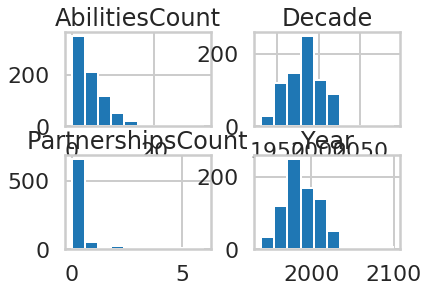

In [22]:
df.hist()

To facilitate reading, histograms can also be based on selected columns.

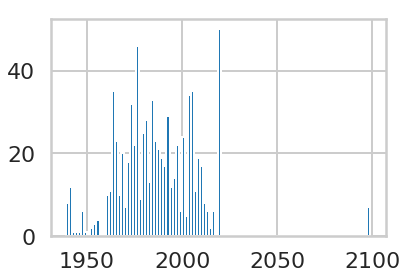

In [23]:
df['Year'].hist(bins=100) # bins determines the number of vertical bars

More complex plots are also possible.

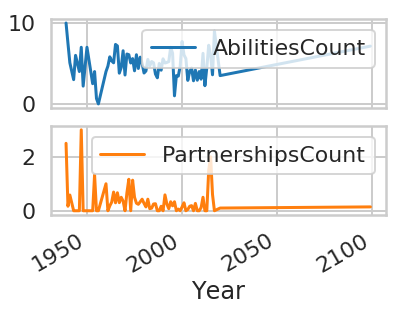

In [24]:
# docs: http://matplotlib.org/api/text_api.html#matplotlib.text.Annotation
#fig = plt.figure()
df[['AbilitiesCount','PartnershipsCount','Year']].groupby("Year").mean().plot(subplots=True)
MaxValue = df['Year'].max()
plt.show()

## Create a Graph from our Data

In the next step, we will create a graph from our data linking the superheroes with their partners and their abilities. Eventually, this will help us to discover which superheroes share abilities.

In [25]:
def createAbilityPartnershipGraphs(consideredDataFrame):
    # for testing purposes it is handy to limit the number of records
    #consideredDataFrame=consideredDataFrame[(consideredDataFrame.Year>=1961) & (consideredDataFrame.Year<1975)]

    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()
    G_abilities=nx.Graph()

    # .itertuples() gives us an iterator over all rows in a data frame
    for row in consideredDataFrame.itertuples():
        hero=row[11]
        year=row[2]
        decade=row[3]
        if not hero in G.nodes():
            G.add_node(hero)
            # the name attribute will be helpful for D3.js visualizations (see below)
            G.node[hero]['name'] = hero
            G.node[hero]['year'] = year
            G.node[hero]['decade'] = decade
            G.node[hero]['group'] = 2 # will change the display color in D3.js and will be used if a text label has to be plotted for this node
            G.node[hero]['picture']=row[9]
            localFilePath=str(row[10])
            if not localFilePath.upper()=="NAN":
                G.node[hero]['localFilePath']=localFilePath
            else:
                G.node[hero]['localFilePath']="N/A" # must not be left empty, otherwise corrupt JSON will be created below

        if not hero in G_abilities.nodes():
            G_abilities.add_node(hero)
            G_abilities.node[hero]['name'] = hero
            G_abilities.node[hero]['year'] = year
            G_abilities.node[hero]['decade'] = decade
            G_abilities.node[hero]['group'] = 2 # will change the display color in D3.js and will be used if a text label has to be plotted for this node
            G_abilities.node[hero]['picture']=row[9]
            localFilePath=str(row[10])
            if not localFilePath.upper()=="NAN":
                G_abilities.node[hero]['localFilePath']=localFilePath
            else:
                G_abilities.node[hero]['localFilePath']="N/A" # must not be left empty, otherwise corrupt JSON will be created below

        # treat partnerships  (PartnershipsCount)  
        if row[7]: # a shortcut to find out whether a string is empty
            if not row[12]=="NAN":
                partners=row[12].split(",")
                for partner in partners:
                    if not partner in G.nodes():
                        G.add_node(partner)
                        G.node[partner]['name'] = partner
                        G.node[partner]['year'] = year
                        G.node[partner]['decade'] = decade
                        G.node[partner]['group'] = 2
                    G.add_edge(hero,partner)
                    G[hero][partner]['year'] = year
                    G[hero][partner]['decade'] = decade
                    # this is a tricky part that is only needed for the later visualization of the results with D3.js
                    # during visualization, we want to hide elements of the graph depending on the associated year.
                    # however, ability nodes linked to different hero nodes (and thus years) must not be hidden.
                    # to prevent this, we check for such nodes and give them a dummy year.
                    edgeList=G.edges(partner,data=True)
                    if len(edgeList)>1:
                        for e in edgeList:
                            G.node[e[0]]['year'] = "XXX"

        # treat abilities
        if row[5]: #AbilitiesCount
            if not row[13]=="NAN":
                abilities=str(row[13]).split(",")
                for ab in abilities:
                    if not ab in G_abilities.nodes():
                        G_abilities.add_node(ab)
                        G_abilities.node[ab]['name'] = ab
                        G_abilities.node[ab]['year'] = year
                        G_abilities.node[ab]['decade'] = decade
                        G_abilities.node[ab]['group'] = 1 # will change the display color in D3.js
                    G_abilities.add_edge(hero,ab)
                    G_abilities[hero][ab]['year'] = year
                    G_abilities[hero][ab]['decade'] = decade
                    # this is a tricky part that is only needed for the later visualization of the results with D3.js
                    # during visualization, we want to hide elements of the graph depending on the associated year.
                    # however, ability nodes linked to different hero nodes (and thus years) must not be hidden.
                    # to prevent this, we check for such nodes and give them a dummy year.
                    edgeList=G_abilities.edges(ab,data=True)
                    if len(edgeList)>1:
                        for e in edgeList:
                            G_abilities.node[e[0]]['year'] = "XXX"
                    #print "Adding edge: "+hero+" - "+str(ab)
                #G_abilities.add_edges_from(list(itertools.product(abilities,abilities))) # macht ein cross product der abilities
    return [G,G_abilities]

r=createAbilityPartnershipGraphs(df)

G=r[0]
G_abilities=r[1]

print("Statistics of the superhero partnership graph.")
print(G.number_of_nodes())
print(G.number_of_edges())

print("\nStatistics of the superhero ability graph.")
print(G_abilities.number_of_nodes())
print(G_abilities.number_of_edges())

Statistics of the superhero partnership graph.
840
189

Statistics of the superhero ability graph.
2910
3831


Usually, you would now like to inspect some properties of the graph. Common properties are discussed [here](https://en.wikipedia.org/wiki/Social_network_analysis).

In [26]:
import networkx.algorithms.approximation.clique as cliq
from networkx.algorithms.approximation.dominating_set import min_weighted_dominating_set
from networkx.algorithms.approximation.independent_set import maximum_independent_set

printLog("assortativity: %f" % nx.degree_assortativity_coefficient(G_abilities))

centralityDegrees=[]
eigenvectorCentralities=[]

centrality=nx.degree_centrality(G_abilities)
#eigenvectorC=nx.eigenvector_centrality(G_abilities)

# https://en.wikipedia.org/wiki/Dominating_set
mwdSet=min_weighted_dominating_set(G_abilities)
dominatingHeroes=[]

for row in df.itertuples():
        hero=row[11]
        if hero in centrality:
            #print "\t"+hero+": "+str(centrality[hero])
            centralityDegrees.append(centrality[hero])
        #if hero in eigenvectorC:
            #eigenvectorCentralities.append(eigenvectorC[hero])
        if hero in mwdSet:
            dominatingHeroes.append(hero)
# errors='ignore' is added for the case that the 'CentralityDegree' column does not exist, e.g., at the first run of this cell
df.drop("CentralityDegree",inplace=True,axis=1,errors='ignore')
df.insert(loc=13,column="CentralityDegree",value=centralityDegrees)
#df.insert(loc=14,column="EigenvectorCentrality",value=eigenvectorCentralities)

# https://en.wikipedia.org/wiki/Clustering_coefficient
printLog("Average clustering coefficient: "+str(nx.average_clustering(G_abilities)))

printLog("\n\nMIN WEIGHTED DOMINATING SET (number of nodes: %i vs. total nodes: %i)\n\n%s"%(len(mwdSet),G_abilities.number_of_nodes(),str(dominatingHeroes)))
# crashes?
#print "\n\nMAX INDEPENDENT SET\n\n"+str(maximum_independent_set(G_abilities))
#extremely slow (NP!!!)
#print cliq.max_clique(G_abilities)
#slow
#print "betweenness_centrality: %s" % str(nwacb.betweenness_centrality(G_abilities))

[2019-02-06 21:06:04.994005]	assortativity: -0.042158
[2019-02-06 21:06:09.125991]	Average clustering coefficient: 3.6731420345093705e-05
[2019-02-06 21:06:09.126975]	

MIN WEIGHTED DOMINATING SET (number of nodes: 2872 vs. total nodes: 2910)

['ABIGAIL BRAND', 'ADEPT', 'AGENT X', 'EL ÁGUILA', 'AIKKU JOKINEN', 'AIR-WALKER - WIKIPEDIA', 'AJAX', 'LIZ ALLAN', 'AMERICAN DREAM', 'AMERICAN EAGLE', 'ANDROMEDA', 'THE ANGEL', 'ANGELA', 'DIRK ANGER', 'ANOLE', 'SCOTT LANG', 'ARABIAN KNIGHT', 'ARAGORN', 'ANYA CORAZON', 'ARCADIA', 'ARCHER', 'ARDINA', 'ARES', 'ARMOR', 'VANCE ASTRO', 'VANCE ASTROVIK', 'ATHENA', 'AURORA', 'BACKHAND', 'BALDER THE BRAVE', 'BANSHEE', 'RIKKI BARNES', 'BASE', 'BATTLESTAR', 'BATWING', 'BAYMAX', 'BEAST', 'BEDLAM', 'BEETLE', 'BENGAL', 'BEREET', 'BETA RAY BILL', 'GOLDEN GIRL', 'BIG BERTHA', 'BIRD-BRAIN', 'BLACK BOLT', 'BLACK CAT', 'BLACK CROW', 'BLACK FOX', 'BLACK JACK TARR', 'BLACK KNIGHT', 'BLACK MARVEL', 'BLACK PANTHER', 'THE BLACK RIDER', 'BLACK WIDOW', 'FIRST APPEARANCE',

In [28]:
df.sort_values(by="CentralityDegree").tail()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps,CentralityDegree
758,Volstagg,1965,1960,"Superb pugilist,Master of the quarterstaff,Exc...",21,NaN,0,https://en.wikipedia.org/wiki/Volstagg,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/758.jpg,VOLSTAGG,NaN,"SUPERB PUGILIST,MASTER OF THE QUARTERSTAFF,EXC...",0.007219
472,Nighthawk,1969,1960,"Kyle (Earth-616):,Superb athlete,Mild superhum...",24,NaN,0,https://en.wikipedia.org/wiki/Nighthawk_(Marve...,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/472.jpg,NIGHTHAWK,NaN,"KYLE (EARTH-616):,SUPERB ATHLETE,MILD SUPERHUM...",0.007906
358,Scarlet Spider,1994,1990,"(As Kaine) :,Superhuman strength,speed,agility...",29,NaN,0,https://en.wikipedia.org/wiki/Kaine_Parker,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/358.jpg,SCARLET SPIDER,NaN,"(AS KAINE) :,SUPERHUMAN STRENGTH,SPEED,AGILITY...",0.008594
337,John Jameson,1963,1960,"Skilled pilot,astronaut,Experienced hand-to-ha...",32,NaN,0,https://en.wikipedia.org/wiki/John_Jameson_(co...,https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/337.png,JOHN JAMESON,NaN,"SKILLED PILOT,ASTRONAUT,EXPERIENCED HAND-TO-HA...",0.009969
654,Speed,2006,2000,"Supersonic speed,Molecular acceleration,Concus...",7,NaN,0,https://en.wikipedia.org/wiki/Speed_(comics),https://upload.wikimedia.org/wikipedia/en/thum...,./web/force/img.marvel_chars/654.png,SPEED,NaN,"SUPERSONIC SPEED,MOLECULAR ACCELERATION,CONCUS...",0.026470


In [29]:
from networkx.algorithms.assortativity.neighbor_degree import average_neighbor_degree
average_neighbor_degree(G_abilities)

{'ABIGAIL BRAND': 5.0,
 'PYROKINESIS': 3.0,
 'ADEPT': 10.333333333333334,
 'HYPER-INVENTION/ HYPER-INTELLIGENCE': 3.0,
 'CHEMICAL MIMICRY/ CREATION': 3.0,
 'ENHANCED STRENGTH': 5.896551724137931,
 'AGENT X': 22.1,
 'REGENERATIVE HEALING FACTOR': 9.909090909090908,
 'SUPERHUMAN AMBIDEXTERITY': 10.0,
 'AGILITY': 10.88888888888889,
 'SPEED': 9.922077922077921,
 'REFLEXES &AMP': 10.0,
 'REACTIONS': 9.333333333333334,
 'COORDINATION': 11.454545454545455,
 'ENDURANCE': 10.294117647058824,
 'EXPERT MARKSMAN': 6.857142857142857,
 'SUBCONSCIOUS TELEPATHIC BLOCKING': 10.0,
 'EL ÁGUILA': 2.75,
 'SKILLED FENCER': 4.0,
 'EXCELLENT ACROBAT': 6.5,
 'HAND TO HAND COMBATANT': 7.25,
 'ELECTRICAL GENERATION': 3.5,
 'AIKKU JOKINEN': 17.714285714285715,
 'ALIEN SUIT GRANTS:': 7.0,
 'FLIGHT': 7.5673076923076925,
 'SHIELD GENERATION': 7.0,
 'INVULNERABILITY': 7.333333333333333,
 'ADAPTABILITY': 7.0,
 'ARSENAL OF LASER BEAMS': 7.0,
 'MINES': 7.0,
 'AIR-WALKER - WIKIPEDIA': 1.0,
 'POWER COSMIC': 1.0,
 'AJAX': 

## Using the Data in Your Website

If you want to display the data on an interactive website for a wider audience, Jupyter notebooks might no longer be appropriate. Fortunately, the networkx package allows us to export the graph data as JSON files which can be easily read by JavaScript.

In [30]:
import json
from networkx.readwrite import json_graph

# create needed subdirectories
if not os.path.exists('./web/force/'):
    os.mkdir('./web/force/')
if not os.path.exists('./web/force/'+pathPrefix+"/"):
    os.mkdir('./web/force/'+pathPrefix+"/")

#d = json_graph.node_link_data(G)
d = json_graph.node_link_data(G_abilities)

    
jsonPath='./web/force/'+pathPrefix+'/force.json'
json.dump(d, open(jsonPath,'w'))

printLog("Saved JSON file to: "+jsonPath)
# weitere notwendige Files für D3.js visualization unter: /Users/david/Documents/src/javascript/visualization
# examples taken from https://github.com/networkx/networkx/tree/master/examples/javascript

[2019-02-06 21:06:26.899185]	Saved JSON file to: ./web/force/marvel/force.json


As graphs can be become to large to be displayed responsively, we will also export the data separated by decades.

In [31]:
decades=[1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020]
dataframes=OrderedDict()
for decade in decades:
    dfTemp=df[(df.Decade==decade)]
    dataframes[decade]=dfTemp

In [32]:
df[df.Decade==2020].describe()

,Year,Decade,AbilitiesCount,PartnershipsCount,CentralityDegree
count,50.0,50.0,50.000000,50.000000,50.000000
mean,2020.0,2020.0,3.500000,0.100000,0.001217
std,0.0,0.0,3.176765,0.505076,0.001103
min,2020.0,2020.0,0.000000,0.000000,0.000000
25%,2020.0,2020.0,1.000000,0.000000,0.000344
50%,2020.0,2020.0,2.500000,0.000000,0.000859
75%,2020.0,2020.0,5.000000,0.000000,0.001719
max,2020.0,2020.0,12.000000,3.000000,0.004125


In [34]:
groupedStats=df[['AbilitiesCount','PartnershipsCount',"Decade"]].groupby("Decade").count()
groupedStats.to_csv("./web/force/"+pathPrefix+"/decadeStats.csv")

In [35]:
for decade in dataframes:
    currentDF=dataframes[decade]
    r=createAbilityPartnershipGraphs(currentDF)
    d = json_graph.node_link_data(r[1])
    jsonPath='./web/force/'+pathPrefix+"/"+str(decade)+'.json'
    json.dump(d, open(jsonPath,'w'))

    printLog("Saved JSON file to: "+jsonPath)

[2019-02-06 21:07:31.638857]	Saved JSON file to: ./web/force/marvel/1900.json
[2019-02-06 21:07:31.642658]	Saved JSON file to: ./web/force/marvel/1910.json
[2019-02-06 21:07:31.646520]	Saved JSON file to: ./web/force/marvel/1920.json
[2019-02-06 21:07:31.651398]	Saved JSON file to: ./web/force/marvel/1930.json
[2019-02-06 21:07:31.662270]	Saved JSON file to: ./web/force/marvel/1940.json
[2019-02-06 21:07:31.667098]	Saved JSON file to: ./web/force/marvel/1950.json
[2019-02-06 21:07:31.712829]	Saved JSON file to: ./web/force/marvel/1960.json
[2019-02-06 21:07:31.755426]	Saved JSON file to: ./web/force/marvel/1970.json
[2019-02-06 21:07:31.789188]	Saved JSON file to: ./web/force/marvel/1980.json
[2019-02-06 21:07:31.818362]	Saved JSON file to: ./web/force/marvel/1990.json
[2019-02-06 21:07:31.849186]	Saved JSON file to: ./web/force/marvel/2000.json
[2019-02-06 21:07:31.863411]	Saved JSON file to: ./web/force/marvel/2010.json
[2019-02-06 21:07:31.880310]	Saved JSON file to: ./web/force/mar

## Displaying the Results

Now we are set to display the results in a browser. However, to prevent security warnings, we cannot directly open the HTML files saved in the web/ directory. Hence, we launch a built-in Python webserver for display.

_ATTENTION_ Never interrupt the kernel after you have started the following cell. Just press <ENTER> in the input field displayed in the cell below.

If you have accidently interrupted the kernel, Python will not release the listener on port 8000. Thus, you will not be able to re-run the following cell. To solve the problem, you must restart the whole Jupyter notebook process.

In [36]:
# if you make changes to http_server.py you will have to delete http_server.pyc manually
import http_server
http_server.load_url('./web/force/force.html')

Webserver working directory: /Users/david/src/CulturalAnalytics


127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/force.html HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/css/sbbbrowse.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/force.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/barchart.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/marvel/force.json HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/marvel/decadeStats.csv HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:39] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:39] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/web/force/img.marvel_chars/0.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:39] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/web/force/img.marvel_chars/1.jpg HTTP/1.1" 404 -
127.0.0.1 - - [0

127.0.0.1 - - [06/Feb/2019 21:07:39] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/web/force/img.marvel_chars/265.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:39] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/web/force/img.marvel_chars/428.JPG HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:39] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/web/force/img.marvel_chars/266.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:39] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/web/force/img.marvel_chars/268.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:39] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/web/force/img.marvel_chars/269.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:39] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:39] "GET /web/force/web/for

127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/force/img.marvel_chars/538.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/force/img.marvel_chars/539.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/force/img.marvel_chars/540.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/force/img.marvel_chars/541.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/force/img.marvel_chars/543.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/for

127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/force/img.marvel_chars/781.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/force/img.marvel_chars/782.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/force/img.marvel_chars/783.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/force/img.marvel_chars/784.JPG HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/force/img.marvel_chars/785.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:40] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:40] "GET /web/force/web/for

127.0.0.1 - - [06/Feb/2019 21:07:57] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:57] "GET /web/force/img.marvel_chars/844.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:57] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:57] "GET /web/force/img.marvel_chars/126.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:57] "GET /web/force/img.marvel_chars/334.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:57] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:57] "GET /web/force/img.marvel_chars/768.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:57] "GET /web/force/img.marvel_chars/590.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:57] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:57] "GET /web/force/img.marvel_chars/684.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:57] "GET /web/force/img.marvel_chars/406.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:57] code 404, message File no

127.0.0.1 - - [06/Feb/2019 21:07:58] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/185.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:58] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/515.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:58] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/720.PNG HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:58] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/316.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:58] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/673.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/61.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/581.jpg HTTP/1.1"

127.0.0.1 - - [06/Feb/2019 21:07:58] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/155.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/200.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/197.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/837.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/833.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/686.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/743.JPG HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/171.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "

127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/233.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/261.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/836.jpg HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/815.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/804.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] code 404, message File not found
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/693.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/323.JPG HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/224.jpg HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2019 21:07:58] "GET /web/force/img.marvel_chars/66.jpg HTTP/1.1" 200 -
127.0.0.1 - - [

Press <RETURN> to stop server

To restart server run: 
python -m http.server 8000
